<a href="https://colab.research.google.com/github/jaesik103/NLP/blob/main/Classfication_SentencePiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proj : 네이버 영화 리뷰 감성 분류에 SentencePiece 적용해보기

- 네이버 영화리뷰 감정 분석 코퍼스에 KoNLPy 형태소 분석기로 Tokenize 후, SentencePiece를 통해 Subword(bpe) 적용시킨 모델 학습하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- sentencePiece로 Tokenize, Subword한 모델과 성능 비교하기


# 1.데이터 준비

In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint

from collections import Counter

In [ ]:
!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
%cd Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab190912.sh
%cd ../

In [ ]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!tar -xzvf korean-english-park.train.tar.gz

In [ ]:
!pip install sentencepiece

In [ ]:
import csv
import sentencepiece as spm

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7f8ba9495b50>)

In [ ]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [ ]:
print('trainv 리뷰 갯수 :', len(train_data))
print('test 리뷰 갯수 :', len(test_data))
# 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

# Nan 결측치 제거
train_data = train_data.dropna(how='any')
test_data = test_data.dropna(how='any')
print('train 리뷰 갯수 :', len(train_data), len(train_data['label']))
print('test 리뷰 갯수 :', len(test_data), len(test_data['label']))

trainv 리뷰 갯수 : 150000
test 리뷰 갯수 : 50000
train 리뷰 갯수 : 146182 146182
test 리뷰 갯수 : 49157 49157


In [ ]:
# 학습용 코퍼스 파일 생성
with open('naver_review_train.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str,train_data['document'])))
# 테스트 코퍼스 파일 생성
with open('naver_review_test.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str,test_data['document'])))

- Mecab-SentencePiece 데이터 준비

In [ ]:
# 센텐스피스 전, macab으로 형태소 분석 토큰화
def mcab_tokenize_and_remove_stopwords(data, stopwords, tokenizer):
    result = []

    for sentence in data:
        curr_data = []
        curr_data = tokenizer.morphs(sentence) # mecab 형태소 분석 tokenizer
        curr_data = [word for word in curr_data if not word in stopwords] # 불용어 제거
        result.append(curr_data)
    
    return result

In [ ]:
# Mecab vocab 만드는 함수

def make_mcab_vocab(train_data, test_data, num_words=40000):

    # 토큰화 및 불용어 제거
    x_train = mcab_tokenize_and_remove_stopwords(train_data['document'], stopwords, tokenizer)
    x_test = mcab_tokenize_and_remove_stopwords(test_data['document'], stopwords, tokenizer)

    # 단어장 만드는 중.....
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(40000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))

    return word_to_index

In [ ]:
# Mecab vocab 생성
mecab_vocab = make_mcab_vocab(train_data, test_data)

with open('mecab_vocab.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(map(str,mecab_vocab.keys())))

In [ ]:
# Mecab vocab을 사용한, 센텐스피스(subword) 임베딩 모델 생성
temp_file = 'mecab_vocab.txt'
vocab_size = 10000
mecab_model_name = 'mecab'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file,mecab_model_name, vocab_size) + '--model_type==bpe'
)

In [ ]:
# 센텐스피스만 적용한 임베딩 모델 생성
temp_file = 'naver_review_train.txt'
vocab_size = 10000
sp_model_name = 'only_spm'
spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix={} --vocab_size={}'.format(temp_file, sp_model_name, vocab_size) + '--model_type==bpe'
)

In [ ]:
# sentence_tokenize

def sentence_tokenize(s, corpus, kind):

    kind_model = kind + '.model'
    vocab_path = './' + kind + '.vocab'

    s.Load(kind_model)

    word_index = {}
    index_word = {}
    stopword_index = [] # 불용어 vocab_index

    with open(vocab_path, 'r') as f:
        vocab = f.readlines()

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})
        if word in stopwords: # 불용어 index 뽑아오기
            stopword_index.append(idx)

    tensor = []

    for sen in corpus:
        tensor_alpha = [] # 한 줄
        for i in s.EncodeAsIds(sen):
            if i not in stopword_index: # 불용어 제거
                tensor_alpha.append(i)
        tensor.append(tensor_alpha)


    tensor_padded = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tensor_padded, word_index, index_word, vocab

In [ ]:
# sentence_tokenize 사용
s = spm.SentencePieceProcessor()
train_data_txt = open('naver_review_train.txt', 'r')
test_data_txt = open('naver_review_test.txt', 'r')

# mecab + setencePiece 임베딩
m_tensor_train,m_tensor_padded_train, m_word_index_train, m_index_word_train, m_vocab_train = sentence_tokenize(s, train_data_txt, mecab_model_name)
m_tensor_test,m_tensor_padded_test, m_word_index_test, m_index_word_test, m_vocab_test = sentence_tokenize(s, test_data_txt, mecab_model_name)

train_data_txt.close()
test_data_txt.close()

# only setencePiece 임베딩

train_data_txt = open('naver_review_train.txt', 'r')
test_data_txt = open('naver_review_test.txt', 'r')

tensor_train,tensor_padded_train, word_index_train, index_word_train, vocab_train = sentence_tokenize(s, train_data_txt, sp_model_name)
tensor_test,tensor_padded_test, word_index_test, index_word_test, vocab_test = sentence_tokenize(s, test_data_txt, sp_model_name)

train_data_txt.close()
test_data_txt.close()

## 1-1.데이터 확인

In [ ]:
train_data

In [ ]:
word_index_train

In [ ]:
index_word_test

In [ ]:
tensor_train

In [ ]:
tensor_padded_train

array([[  61,  868,    5, ...,    0,    0,    0],
       [1667,    8, 4959, ...,    0,    0,    0],
       [  22,  366, 9783, ...,    0,    0,    0],
       ...,
       [ 140,  168,   62, ...,    0,    0,    0],
       [1882,  567, 5308, ...,    0,    0,    0],
       [ 258,    7, 4131, ...,    0,    0,    0]], dtype=int32)

In [ ]:
m_tensor_padded_train

array([[  43,  393,  927, ...,    0,    0,    0],
       [1671, 1029, 3905, ...,    0,    0,    0],
       [   3,  756,  127, ...,    0,    0,    0],
       ...,
       [  30,  203, 2334, ...,    0,    0,    0],
       [6454, 1081, 3130, ...,    0,    0,    0],
       [1343, 1081,  322, ...,    0,    0,    0]], dtype=int32)

## 1-2. 데이터 분석

In [ ]:
def data_analysis(model_name, tensor_train, tensor_test):
    # 데이터셋 내 문장 길이 분포
    print(model_name)
    total_data_text = list(tensor_train) + list(tensor_test)

    # 텍스트데이터 문장길이의 리스트를 생성한 후
    num_tokens = [len(tokens) for tokens in total_data_text]
    num_tokens = np.array(num_tokens)

    # 문장 길이의 평균값, 최대값, 표준편차를 계산
    print('문장길이 평균 :', np.mean(num_tokens))
    print('문장길이 최대 :', np.max(num_tokens))
    print('문장길이 표준편차 :', np.std(num_tokens))

    # 예를 들어 최대 길이를 (평균 + 2*표준편차)로 한다면,
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)

    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ', maxlen)
    print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/ len(num_tokens)))
    print()

In [ ]:
data_analysis(mecab_model_name, m_tensor_train, m_tensor_test)
data_analysis(sp_model_name, tensor_train, tensor_test)

mecab
문장길이 평균 : 20.291114421595278
문장길이 최대 : 136
문장길이 표준편차 : 16.555555298772237
pad_sequences maxlen :  53
전체 문장의 0.9347954069591837%가 maxlen 설정값 이내에 포함됩니다. 

only_spm
문장길이 평균 : 15.423893846082963
문장길이 최대 : 130
문장길이 표준편차 : 13.017725583781521
pad_sequences maxlen :  41
전체 문장의 0.9372577928626644%가 maxlen 설정값 이내에 포함됩니다. 



# 2.모델 구성 및 validation 구성

## 2.1 validation 데이터

In [ ]:
def validation_generator(train_tensor_padded, train_label_data, test_tensor_padded, test_label_data, data_size):
    
    x = train_tensor_padded[data_size:]
    # 같은 shape로 바꿔주기
    y = []
    llist = []
    for i in list(train_label_data):
        llist.append(i)
        y.append(llist)
        llist = []
    y = np.array(y)[data_size:]

    # val
    x_val = test_tensor_padded[:data_size]
    # 같은 shape로 바꿔주기
    y_val = []
    llist = []
    for i in list(test_label_data):
        llist.append(i)
        y_val.append(llist)
        llist = []
    y_val = np.array(y_val)[:data_size]

    return x, y, x_val, y_val


## 2.2 LSTM

In [ ]:
vocab_size = 10000
word_vector_dim = 16


Embedding_layer1 = keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
LSTM_layer1 = keras.layers.LSTM(128, return_sequences=True)
dense_layer1 = keras.layers.Dense(64, activation='relu')
Dropout_layer = keras.layers.Dropout(.5)
bn_layer = keras.layers.BatchNormalization()
dense_layer2 = keras.layers.Dense(1, activation='sigmoid')
 
model = Sequential([
        Embedding_layer1,
        LSTM_layer1,
        Dropout_layer,
        bn_layer,
        dense_layer1,
        Dropout_layer,
        dense_layer2
        ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 batch_normalization (BatchN  (None, None, 128)        512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, None, 64)          8256      
                                                                 
 dense_1 (Dense)             (None, None, 1)           65        
                                                        

In [ ]:
# mecab-sentencPiece
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('m_best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

epochs = 100

x, y, x_val, y_val = validation_generator(m_tensor_padded_train, train_data['label'], m_tensor_padded_test, test_data['label'], 50000)

m_history = model.fit(x, y, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1, callbacks=[es, mc])

Epoch 1/100
188/188 [==============================] - 27s 102ms/step - loss: 0.5216 - accuracy: 0.7249 - val_loss: 0.5824 - val_accuracy: 0.7816
Epoch 2/100
188/188 [==============================] - 19s 101ms/step - loss: 0.3984 - accuracy: 0.8270 - val_loss: 0.5131 - val_accuracy: 0.8128
Epoch 3/100
188/188 [==============================] - 18s 96ms/step - loss: 0.3830 - accuracy: 0.8349 - val_loss: 0.4333 - val_accuracy: 0.8157
Epoch 4/100
188/188 [==============================] - 19s 100ms/step - loss: 0.3714 - accuracy: 0.8396 - val_loss: 0.4107 - val_accuracy: 0.8154
Epoch 5/100
188/188 [==============================] - 19s 100ms/step - loss: 0.3601 - accuracy: 0.8427 - val_loss: 0.4052 - val_accuracy: 0.8156
Epoch 6/100
188/188 [==============================] - 18s 98ms/step - loss: 0.3462 - accuracy: 0.8489 - val_loss: 0.4046 - val_accuracy: 0.8193
Epoch 7/100
188/188 [==============================] - 18s 98ms/step - loss: 0.3366 - accuracy: 0.8538 - val_loss: 0.4208 - va

In [ ]:
# mecab-sentencPiece
m_model = load_model('/content/m_best_model.h5')

results = m_model.evaluate(x_val, y_val, verbose=2)

1537/1537 - 18s - loss: 0.4007 - accuracy: 0.8215 - 18s/epoch - 12ms/step


In [ ]:
# Only_sentencePiece
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

epochs = 100

x, y, x_val, y_val = validation_generator(tensor_padded_train, train_data['label'], tensor_padded_test, test_data['label'], 50000)

history = model.fit(x, y, epochs=epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1, callbacks=[es, mc])

Epoch 1/100
188/188 [==============================] - 21s 96ms/step - loss: 0.6556 - accuracy: 0.5901 - val_loss: 0.4459 - val_accuracy: 0.8055
Epoch 2/100
188/188 [==============================] - 17s 92ms/step - loss: 0.3810 - accuracy: 0.8371 - val_loss: 0.3909 - val_accuracy: 0.8279
Epoch 3/100
188/188 [==============================] - 17s 92ms/step - loss: 0.3413 - accuracy: 0.8562 - val_loss: 0.3745 - val_accuracy: 0.8346
Epoch 4/100
188/188 [==============================] - 17s 93ms/step - loss: 0.3225 - accuracy: 0.8654 - val_loss: 0.3781 - val_accuracy: 0.8340
Epoch 5/100
188/188 [==============================] - 18s 93ms/step - loss: 0.3096 - accuracy: 0.8698 - val_loss: 0.3819 - val_accuracy: 0.8321
Epoch 6/100
188/188 [==============================] - 18s 94ms/step - loss: 0.2888 - accuracy: 0.8788 - val_loss: 0.3819 - val_accuracy: 0.8322
Epoch 7/100
188/188 [==============================] - 18s 94ms/step - loss: 0.2636 - accuracy: 0.8888 - val_loss: 0.4444 - val_ac

In [ ]:
# Only_sentencePiece
model = load_model('/content/best_model.h5')

results = model.evaluate(x_val, y_val, verbose=2)

1537/1537 - 18s - loss: 0.3745 - accuracy: 0.8346 - 18s/epoch - 12ms/step


# 3.결과

## 3.1 그래프

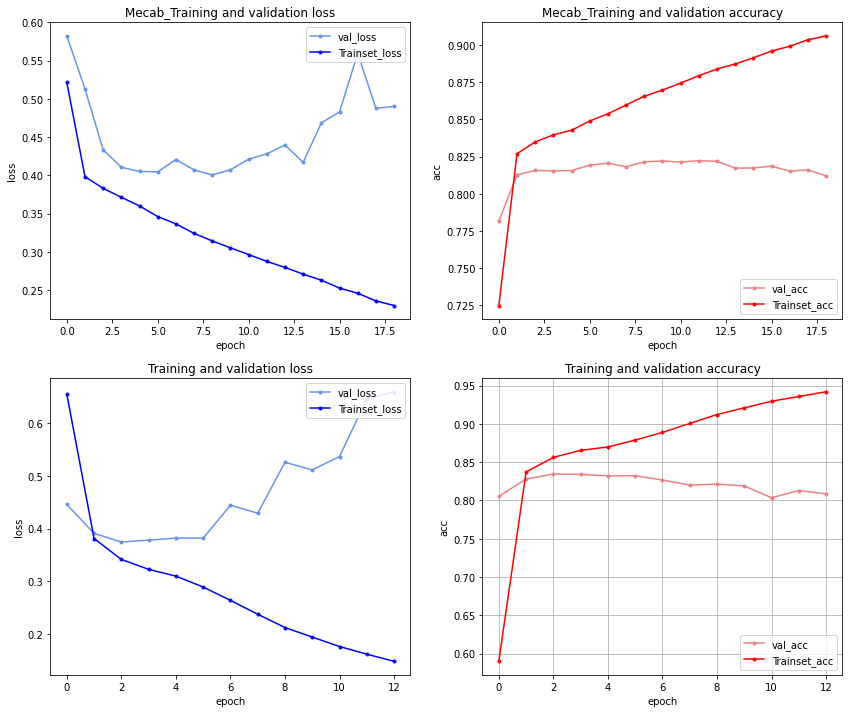

In [ ]:
# mecab-sentencPiece

m_acc= m_history.history['accuracy']
m_val_acc= m_history.history['val_accuracy']
m_y_vloss = m_history.history['val_loss']
m_y_loss = m_history.history['loss']

m_x_len = np.arange(len(m_y_loss)) 

plt.figure(figsize=(8, 12))
plt.subplot(2, 2, 1)               
plt.plot(m_x_len, m_y_vloss, marker='.', c="cornflowerblue", label='val_loss')
plt.plot(m_x_len, m_y_loss, marker='.', c="blue", label='Trainset_loss')
plt.title('Mecab_Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)               
plt.plot(m_x_len, m_val_acc, marker='.', c="lightcoral", label='val_acc')
plt.plot(m_x_len, m_acc, marker='.', c="red", label='Trainset_acc')
plt.title('Mecab_Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.subplots_adjust(right=1.5)
plt.legend(loc='lower right') 

# Only_sentencePiece

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.subplot(2, 2, 3)              
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='val_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.title('Training and validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

plt.subplot(2, 2, 4)                
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='val_acc')
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.subplots_adjust(right=1.5)
plt.legend(loc='lower right') 

plt.grid()
plt.show()

## 3.2 예측

In [ ]:
with open('review.txt', 'w') as c:
    txt = "명작이다."
    c.write(txt)

In [ ]:
with open('review.txt', 'r') as c:
    review = c.readlines()

In [ ]:
# 비교
m_model = load_model('/content/m_best_model.h5')
model = load_model('/content/best_model.h5')

a, m_tensor_padded, c, d, e = sentence_tokenize(s, review, mecab_model_name) # 토큰 + 패딩
a, tensor_padded, c, d, e = sentence_tokenize(s, review, sp_model_name) # 토큰 + 패딩

m_score = m_model.predict(m_tensor_padded)
score = model.predict(tensor_padded)
print(review)
print('위가 mecab-sentencPiece, 아래가 Only_sentencePiece')
print('-------------------------')

for i in range(len(m_score)):
    m_confidence = (sum(m_score[i])/len(m_score[i]))*100
    if m_confidence > 50:
        print('{}번째 리뷰 : {}'.format(i+1,review[i]))
        print('m-s긍정 : {: .2f}%'.format(float(m_confidence)))
        
    if m_confidence <= 50:
        print('{}번째 리뷰 : {}'.format(i+1, review[i]))
        print('m-s부정 : {: .2f}%'.format(float(100-m_confidence)))
    
    confidence = (sum(score[i])/len(score[i]))*100
    if confidence > 50:
        print('s긍정 : {: .2f}%'.format(float(confidence)))
        print('---------------------------------------------')
        
    if confidence <= 50:
        print('s부정 : {: .2f}%'.format(float(100-confidence)))
        print('---------------------------------------------')


['명작이다.\n', '인생영화 였어요.\n', '이딴것도 영화라고 만들었냐?\n', '시간남는 분만 보세요\n', '이 영화는 재밌을 수도, 없을 수도 있습니다.\n', '개꿀잼\n', '개노잼\n']
위가 mecab-sentencPiece, 아래가 Only_sentencePiece
-------------------------
1번째 리뷰 : 명작이다.

m-s긍정 :  90.82%
s긍정 :  95.86%
---------------------------------------------
2번째 리뷰 : 인생영화 였어요.

m-s긍정 :  87.66%
s긍정 :  75.00%
---------------------------------------------
3번째 리뷰 : 이딴것도 영화라고 만들었냐?

m-s부정 :  90.56%
s부정 :  96.28%
---------------------------------------------
4번째 리뷰 : 시간남는 분만 보세요

m-s부정 :  78.22%
s부정 :  63.92%
---------------------------------------------
5번째 리뷰 : 이 영화는 재밌을 수도, 없을 수도 있습니다.

m-s긍정 :  60.56%
s부정 :  51.39%
---------------------------------------------
6번째 리뷰 : 개꿀잼

m-s긍정 :  90.63%
s긍정 :  91.53%
---------------------------------------------
7번째 리뷰 : 개노잼

m-s부정 :  97.13%
s부정 :  96.09%
---------------------------------------------
